# STEP 1: Imports and Get Data

In [1]:
from model_components.data_reader import FinancialTimeSeriesDataset, verify_financial_dataloader
from model_components.transformers import TimeSeriesTransformer
from model_components.fin_trainer import TimeSeriesForecastingTrainer
from model_components.utils import (
    create_optimizer,
    create_scheduler,
    plot_lr_schedule
)
  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
import wandb
import yaml
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [2]:
%%writefile config.yaml

Name                      : "Nayesha-Gopal"

###### Dataset -----------------------------------------------------------------
data:                    # Currently setup for Colab assuming out setup
  root                 : "/local/hw4_data/hw4p1_data"  # TODO: Set the root path of your data
  train_partition      : "train"  # train
  val_partition        : "val"    # val
  test_partition       : "test"   # test
  subset               : 1.0      # Load a subset of the data (for debugging, testing, etc
  batch_size           : 256      #
  NUM_WORKERS          : 2        # Set to 0 for CPU
  forecast_horizon     : 5

###### Network Specs -------------------------------------------------------------
model: # Decoder-Only Language Model (HW4P1)
  d_model                   : 256
  d_ff                      : 1024
  d_freq                    : 3    #how many dimensions to split time into- must be odd because it adds 1?
  num_layers                : 2
  num_heads                 : 2
  dropout                   : 0.0

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : True   # Toggle wandb logging
  wandb_run_id                : "none" # "none" or "run_id"
  resume                      : False  # Resume an existing run (run_id != 'none')
  epochs                      : 10
  gradient_accumulation_steps : 1
  wandb_project               : "IDL_final project PegasusNG" # wandb project to log to

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' CrossEntropy
  label_smoothing: 0.0

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adamw" # Options: sgd, adam, adamw
  lr: 5.0e-4   # Base learning rate

  # Common parameters
  weight_decay: 0.0001

  # Parameter groups
  param_groups:
    - name: self_attn
      patterns: []  # Will match all parameters containing keywords set their learning rate to 0.0001
      lr: 0.0001    # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8

    - name: ffn
      patterns: [] # Will match all parameters containing "ffn" and set their learning rate to 0.0001
      lr: 0.0001   # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8

  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1.0e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 15  # Maximum number of iterations
    eta_min: 1.0e-8  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 4  # Number of iterations for the first restart
    T_mult: 4  # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: True
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0

Overwriting config.yaml


In [3]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
# we can add a val ratio element to this as well
train_dataset = FinancialTimeSeriesDataset(
    tickers=['^SPX'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=30,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='zscore',
    split='train',
    val_ratio=0.25
)

val_dataset = FinancialTimeSeriesDataset(
    tickers=['^SPX'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=30,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='zscore',
    split='val',
    val_ratio=0.25
)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Processing ^SPX (train):   0%|                                                                                    | 0/926 [00:00<?, ?it/s]

Processing ^SPX (train): 100%|███████████████████████████████████████████████████████████████████████| 926/926 [00:00<00:00, 17413.35it/s]


[*********************100%***********************]  1 of 1 completed

Processing ^SPX (val):   0%|                                                                                      | 0/298 [00:00<?, ?it/s]

Processing ^SPX (val): 100%|█████████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 70611.98it/s]

In [5]:
# DATALOADERS
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = True,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

In [6]:
# verify dataloader
verify_financial_dataloader(train_loader)
verify_financial_dataloader(val_loader)

        Financial Dataloader Verification         
Dataloader Partition     : train
--------------------------------------------------
Number of Batches        : 4
Batch Size               : 256
--------------------------------------------------
Checking shapes of the first batch...             

Past Window Shape        : [256, 30, 6]
Future Target Shape      : [256, 5, 1]
--------------------------------------------------
Window Size              : 30
Forecast Horizon         : 5
Num Input Features       : 6 (includes Time)
Target Feature           : Close
        Financial Dataloader Verification         
Dataloader Partition     : val
--------------------------------------------------
Number of Batches        : 2
Batch Size               : 256
--------------------------------------------------
Checking shapes of the first batch...             

Past Window Shape        : [256, 30, 6]
Future Target Shape      : [256, 5, 1]
--------------------------------------------------
Window Si

# STEP 2: Set Up Model

In [7]:
model_config = config['model']
# update this to add model input and output features
print(train_dataset.input_features, val_dataset.output_features)
model_config.update({
    'input_features': train_dataset.input_features,
    'output_features': val_dataset.output_features,              #hardcoded, TODO NEED TO FIX
    'forecast_horizon':  config['data']['forecast_horizon']
})
model = TimeSeriesTransformer(**model_config)

# CONFIRM EVERYTHING IS BEING LOADED CORRECTLY
for batch in train_loader:
    inputs, targets = batch

    print("First input sample (shape: {}):".format(inputs[0].shape))
    print(inputs[0])  # shape: [T, F]

    print("Corresponding target (shape: {}):".format(targets[0].shape))
    print(targets[0])  # shape: [forecast_steps]

    print("Inputs:", inputs.shape)
    print("Targets:", targets.shape)
    break

outputs = model(inputs)  # or model(inputs, something_else) if needed
print(outputs.shape)

model_stats = summary(model, input_data=inputs.to("cpu"), device="cpu")
print(model_stats)

6 1


First input sample (shape: torch.Size([30, 6])):


tensor([[2.0806e+03, 2.0806e+03, 2.0651e+03, 2.0743e+03, 3.2218e+09, 7.4000e+01],
        [2.0728e+03, 2.1069e+03, 2.0612e+03, 2.0995e+03, 4.1282e+09, 7.5000e+01],
        [2.0987e+03, 2.0987e+03, 2.0856e+03, 2.0893e+03, 3.3052e+09, 7.6000e+01],
        [2.0903e+03, 2.1139e+03, 2.0903e+03, 2.1081e+03, 5.5541e+09, 7.7000e+01],
        [2.1080e+03, 2.1149e+03, 2.1044e+03, 2.1044e+03, 3.2680e+09, 8.0000e+01],
        [2.1039e+03, 2.1076e+03, 2.0915e+03, 2.0915e+03, 3.1898e+09, 8.1000e+01],
        [2.0931e+03, 2.0974e+03, 2.0611e+03, 2.0611e+03, 3.5211e+09, 8.2000e+01],
        [2.0599e+03, 2.0671e+03, 2.0455e+03, 2.0561e+03, 3.5107e+09, 8.3000e+01],
        [2.0558e+03, 2.0628e+03, 2.0530e+03, 2.0610e+03, 3.0085e+09, 8.4000e+01],
        [2.0641e+03, 2.0890e+03, 2.0641e+03, 2.0862e+03, 2.9177e+09, 8.7000e+01],
        [2.0841e+03, 2.0841e+03, 2.0670e+03, 2.0679e+03, 3.3765e+09, 8.8000e+01],
        [2.0676e+03, 2.0676e+03, 2.0484e+03, 2.0597e+03, 3.5433e+09, 8.9000e+01],
        [2.0600e

torch.Size([256, 5, 1])


Layer (type:depth-idx)                        Output Shape              Param #
TimeSeriesTransformer                         [256, 5, 1]               --
├─Linear: 1-1                                 [256, 30, 256]            1,536
├─Time2VecTorch: 1-2                          [256, 30, 4]              8
├─Dropout: 1-3                                [256, 30, 260]            --
├─Linear: 1-4                                 [256, 5, 256]             (recursive)
├─Time2VecTorch: 1-5                          [256, 5, 4]               (recursive)
├─Dropout: 1-6                                [256, 5, 260]             --
├─TransformerDecoder: 1-7                     [256, 5, 260]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerDecoderLayer: 3-1      [256, 5, 260]             1,078,204
│    │    └─TransformerDecoderLayer: 3-2      [256, 5, 260]             1,078,204
├─LayerNorm: 1-8                              [256, 5, 260]  

# STEP 3: Setup WandB and Trainer

In [8]:
wandb.login(key="b78dba2c54228a3e3e32bd91a1a1efca38d69bb9")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/gandotra/.netrc


wandb: Currently logged in as: nayeshag (nayeshag-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
trainer = TimeSeriesForecastingTrainer(
    model=model,
    config=config,
    run_name="test-1-fin",
    config_file="config.yaml",
    device=device
)

True


wandb: Tracking run with wandb version 0.19.9


wandb: Run data is saved locally in /ocean/projects/cis250019p/gandotra/IDL_project/wandb/run-20250418_185224-91sgr0bu
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run test-1-fin


wandb: ⭐️ View project at https://wandb.ai/nayeshag-carnegie-mellon-university/IDL_final%20project%20PegasusNG


wandb: 🚀 View run at https://wandb.ai/nayeshag-carnegie-mellon-university/IDL_final%20project%20PegasusNG/runs/91sgr0bu



🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0005
├── Weight Decay: 0.0001
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False



📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (60 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (20 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


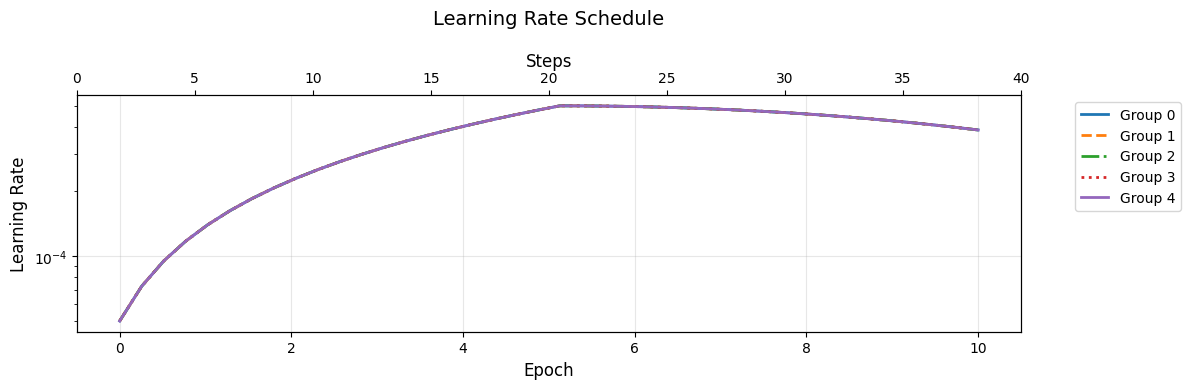


📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (60 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (20 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


In [10]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)

test_scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=test_scheduler,
    num_epochs=config['training']['epochs'],

    
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)


# Step 4: TRAIN!!   

In [11]:
trainer.train(train_loader, val_loader, epochs=config['training']['epochs'])

Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

Training:   0%|                                                                  | 0/4 [00:45<?, ?it/s, accuracy=0.00%, loss=nan, mae=nan]

Training:  25%|██████████████▌                                           | 1/4 [00:46<02:18, 46.01s/it, accuracy=0.00%, loss=nan, mae=nan]

Training:  25%|██████████████▌                                           | 1/4 [01:25<02:18, 46.01s/it, accuracy=0.00%, loss=nan, mae=nan]

Training:  50%|█████████████████████████████                             | 2/4 [01:25<01:24, 42.06s/it, accuracy=0.00%, loss=nan, mae=nan]

Training:  50%|█████████████████████████████                             | 2/4 [02:14<01:24, 42.06s/it, accuracy=0.00%, loss=nan, mae=nan]

Training:  75%|███████████████████████████████████████████▌              | 3/4 [02:14<00:45, 45.14s/it, accuracy=0.00%, loss=nan, mae=nan]